In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


In [2]:
import os
import numpy as np
import pandas as pd
import pandas_profiling as pp
import matplotlib.pyplot as plt
import seaborn as sns
import math


from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint
from sklearn.metrics import accuracy_score, precision_score, classification_report, plot_confusion_matrix, roc_curve, auc
import plotly.offline as pyo
import plotly. graph_objs as go
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import warnings 
warnings.filterwarnings('ignore')



**Importing and Reading the dataset**

In [3]:
data = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


**Checking missing values in data**

In [4]:
data.isnull().sum().sum()

0

In [5]:
pd.set_option("display.float", "{:.2f}".format)
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,...,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00
mean,94813.86,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,...,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,88.35,0.00
std,47488.15,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,...,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,250.12,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,...,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,54201.50,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,...,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.60,0.00
50%,84692.00,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,...,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,139320.50,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,...,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.16,0.00
max,172792.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,...,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,25691.16,1.00


**Checking if data is balanced or not**

In [6]:
output_counts = data['Class'].value_counts()
trace0=go.Bar(x=['No Fraud'], y =[output_counts[0]], name ='No Fraud')
trace1=go.Bar(x=['Fraud'], y=[output_counts[1]], name ='Fraud')
data = [trace0, trace1]
layout = go.Layout(template ='plotly_dark', title = 'No Fraud vs Fraud')
fig = go.Figure(data = data , layout = layout)
fig.show()

**As we can see data is not balanced so we need to do sampling. The prediction will not be accurate as the model will train itself on majority of data which is for legal transactions. This will cause overfitting.** 

In [7]:
#x = data.drop('Class', axis=1)
data = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")
y = data['Class']
x= data.drop('Class', axis=1)
train_X,test_X,train_Y,test_Y = train_test_split(x,y,train_size = 0.2,random_state = 42)

**Sampling the data**

There are three types of sampling:
1. **Under Sampling** - In this type of sampling we make samples of majority class equal to the samples of minority class. But in this case we may lose some important data as we are removing the majority class samples to make it equal to minority class samples.

2. **Over Sampling** - In this type of sampling we make samples of minority class equal to the samples of majority class.

3. **Synthetic Sampling** - In this type of sampling we add dummy samples in minority class based on the available data

Below down you will see that I have used pipeline to use all three types of sampling to see which one performs better.

In [8]:
from sklearn.utils import resample

training_set = pd.concat([train_X, train_Y], axis=1)
fraud = training_set[training_set.Class==1]
No_fraud = training_set[training_set.Class==0]

# Undersampling the majority
undersample = resample(No_fraud, 
                       replace=True, 
                       n_samples=len(fraud), #set the number of samples to equal the number of the minority class
                       random_state=42)
# Returning to new training set
undersample_train = pd.concat([fraud, undersample])
undersample_train.Class.value_counts(normalize=True)

undersample_x_train = undersample_train.drop('Class', axis=1)
undersample_y_train = undersample_train.Class

In [9]:
oversample = resample(fraud, 
                       replace=True, 
                       n_samples=len(No_fraud), #set the number of samples to equal the number of the majority class
                       random_state=42)
# Returning to new training set
oversample_train = pd.concat([No_fraud, oversample])
oversample_train.Class.value_counts(normalize=True)

oversample_x_train = oversample_train.drop('Class', axis=1)
oversample_y_train = oversample_train.Class

In [10]:
# Import the SMOTE package
from imblearn.over_sampling import SMOTE
# Synthesize minority class datapoints using SMOTE
sm = SMOTE(random_state=42, sampling_strategy='minority')
smote_x_train, smote_y_train = sm.fit_resample(train_X, train_Y)
# Separate into training and test sets
smote_x_train = pd.DataFrame(smote_x_train, columns = train_X.columns)
smote_y_train = pd.DataFrame(smote_y_train, columns = ['Class'])

#fraud = data[data['Class']==1]
#legal = data[data['Class']==0]
plt.figure(figsize=(10,8))
sns.heatmap(data=data.corr(), cmap="seismic")
plt.show();

In [11]:
set_x =[undersample_x_train, oversample_x_train, smote_x_train] 
set_y =[undersample_y_train, oversample_y_train, smote_y_train]

LogisticRegressionModel got 99.78% Accuracy.
RandomForestModel got 97.72% Accuracy.
[13:47:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoostClassifier got 96.77% Accuracy.
KNeighborsClassifier got 99.64% Accuracy.
SVMClassifier got 99.48% Accuracy.
DecisionTreeClassifier got 90.42% Accuracy.


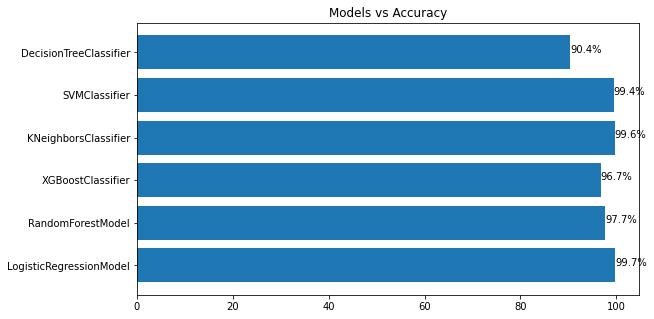

In [12]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

all_models = {
    "LogisticRegressionModel": LogisticRegression(),
    "RandomForestModel": RandomForestClassifier(random_state = 18),
    "XGBoostClassifier": XGBClassifier(random_state = 18, ),
    "KNeighborsClassifier": KNeighborsClassifier(n_neighbors=15),
    "SVMClassifier": SVC(),
    "DecisionTreeClassifier":DecisionTreeClassifier(),
}

model_names = []
model_scores = []

for model_name in all_models:
    pipeline = make_pipeline(MinMaxScaler(), all_models[model_name])
    pipeline.fit(undersample_x_train, undersample_y_train)
    predictions = pipeline.predict(test_X)
    accuracy = accuracy_score(test_Y, predictions)
    model_names.append(model_name)
    model_scores.append(accuracy * 100)
    print(f"{model_name} got {str(accuracy*100)[:5]}% Accuracy.")

plt.figure(figsize = (9,5))
plt.barh(model_names, model_scores)
  
for index, value in enumerate(model_scores):
    plt.text(value, index,
             str(value)[:4]+"%")

plt.title("Models vs Accuracy")
plt.show()

**As you can see above using undersampling Decision tree, XGBoost and Random Forest performs good. Others are having accuracy of 99% which is not possible. So we can ignore those.**  

LogisticRegressionModel got 98.30% Accuracy.
RandomForestModel got 99.94% Accuracy.
[14:18:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoostClassifier got 99.94% Accuracy.
SVMClassifier got 99.24% Accuracy.
DecisionTreeClassifier got 99.88% Accuracy.


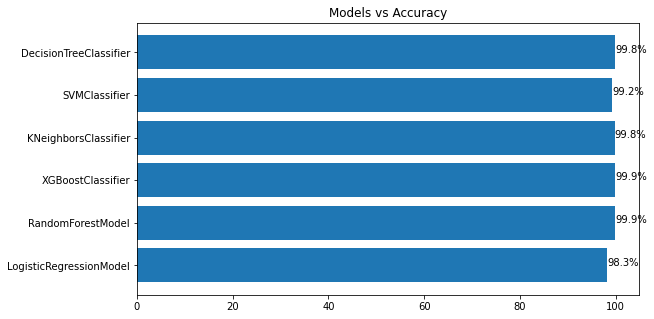

In [15]:
model_names_over = []
model_scores_over = []

for model_name in all_models:
    pipeline = make_pipeline(MinMaxScaler(), all_models[model_name])
    pipeline.fit(oversample_x_train, oversample_y_train)
    predictions = pipeline.predict(test_X)
    accuracy = accuracy_score(test_Y, predictions)
    model_names_over.append(model_name)
    model_scores_over.append(accuracy * 100)
    print(f"{model_name} got {str(accuracy*100)[:5]}% Accuracy.")

plt.figure(figsize = (9,5))
plt.barh(model_names_over, model_scores_over)
  
for index, value in enumerate(model_scores_over):
    plt.text(value, index,
             str(value)[:4]+"%")

plt.title("Models vs Accuracy")
plt.show()

**As you can see above using oversampling that almost all models are having accuracy of 99% except Logistic regression.** 

LogisticRegressionModel got 99.31% Accuracy.
RandomForestModel got 99.94% Accuracy.
[14:33:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoostClassifier got 99.93% Accuracy.
KNeighborsClassifier got 99.72% Accuracy.
SVMClassifier got 99.71% Accuracy.
DecisionTreeClassifier got 99.78% Accuracy.


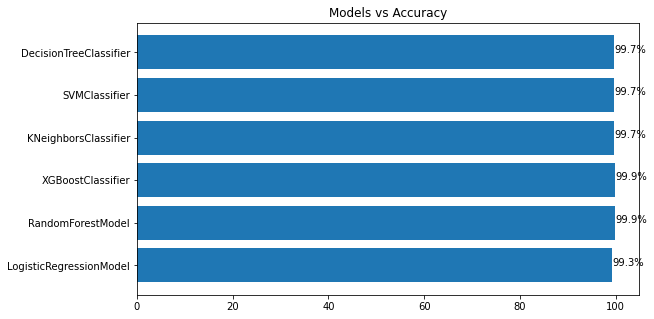

In [16]:
model_names_synthetic = []
model_scores_synthetic = []
for model_name in all_models:
    pipeline = make_pipeline(MinMaxScaler(), all_models[model_name])
    pipeline.fit(smote_x_train, smote_y_train)
    predictions = pipeline.predict(test_X)
    accuracy = accuracy_score(test_Y, predictions)
    model_names_synthetic.append(model_name)
    model_scores_synthetic.append(accuracy * 100)
    print(f"{model_name} got {str(accuracy*100)[:5]}% Accuracy.")

plt.figure(figsize = (9,5))

plt.barh(model_names_synthetic, model_scores_synthetic)
  
for index, value in enumerate(model_scores_synthetic):
    plt.text(value, index,
             str(value)[:4]+"%")

plt.title("Models vs Accuracy")
plt.show()

**Using synthetic sampling all are giving 99% accuracy.** 

**Seeing the above results you can use logistic regression model with over sampling or you can use decision tree/Random forest/XGBoost with under sampling.**